# Intro

Goal: 

- trying out basic GLM on simulated data
- demonstrate what happens if there is a linear or log relationship with a feature
- how annualised models work - what happens if we have a time factor with an assumed linear relationship with expected value? 

In [40]:
import numpy as np
import pandas as pd

from sklearn.linear_model import PoissonRegressor
from sklearn.metrics import mean_poisson_deviance

from matplotlib import pyplot as plt
import seaborn as sns

TODO: 
- it seems like the tol is the maximum of the gradient, but then what's the point...? that's very loose
- recalculate likelihoods, how does it work with a regularisation factor? 
- GLM from scratch? 

# Poisson 1

We have one continuous feature. The lambda parameter has a linear relationship with the feature. 

Mistakes you can make: 
- not applying a log transformation
- leaving alpha at default

In [2]:
# generate data
# we have one feature, feature_1, and Poisson lambda is going to be linear by it

df = pd.DataFrame.from_dict({'feature_1' : np.repeat(range(1000,10001),100)})
df['lambda'] = df['feature_1'] / 10000
df['claim_number'] = np.random.poisson(df['lambda'])
df['log_feature_1'] = np.log(df['feature_1'])

In [3]:
sum(df['lambda'])

495054.99999998964

In [4]:
sum(df['claim_number'])

493848

In [5]:
# In log-link GLM turns, what we want is so this: 
# predicted = 1/10000 * feature_1 ^ 1
# mdl_coef should be 1, while mdl_intercept should be log(1/10000)
np.log(1/10000)

-9.210340371976182

## Without Log Transformation

Let's see what happens if we try to put in the feature as it is. 

## With Default 1 Regularisation

In [6]:
mdl = PoissonRegressor()
X = df[['log_feature_1']]
y = df['claim_number']
mdl.fit(X, y)
df['pred_claim_number'] = mdl.predict(X)

In [7]:
df.sample(5)

,feature_1,lambda,claim_number,log_feature_1,pred_claim_number
195983,2959,0.2959,1,7.992607,0.517219
513139,6131,0.6131,1,8.721113,0.566230
581012,6810,0.6810,1,8.826147,0.573669
733705,8337,0.8337,0,9.028459,0.588275
47582,1475,0.1475,0,7.296413,0.474351


In [8]:
mdl.intercept_

-1.652554084043818

In [9]:
mdl.coef_

array([0.12427297])

In [10]:
df[df.feature_1 == 10000][:1]

,feature_1,lambda,claim_number,log_feature_1,pred_claim_number
900000,10000,1.0,2,9.21034,0.601723


In [11]:
np.exp(mdl.intercept_ + np.log(10000) * mdl.coef_[0])

0.6017232160978054

In [12]:
# alternatively: 
np.exp(mdl.intercept_) * 10000 ** mdl.coef_[0]

0.6017232160978053

The reason of course is the regularisation parameter. Let's try to demonstrate why this is the maximum intercept - coef pair under regularisation parameter 1. 

$\alpha$ is supposed to be the L2 regularisation. 

Handy summary of the model objective function here: https://scikit-learn.org/stable/modules/linear_model.html#generalized-linear-models

In [13]:
def predict_lambda(log_feature_1, intercept, coef):
    return np.exp(intercept + log_feature_1 * coef)

In [14]:
my_pred = predict_lambda(df['log_feature_1'], mdl.intercept_, mdl.coef_)

df['my_pred'] = my_pred

In [15]:
df.sample(3)

,feature_1,lambda,claim_number,log_feature_1,pred_claim_number,my_pred
523764,6237,0.6237,3,8.738255,0.567437,0.567437
597895,6978,0.6978,0,8.850518,0.575409,0.575409
22013,1220,0.1220,0,7.106606,0.463293,0.463293


In [16]:
def calculate_model_objective(actu, log_feature_1, intercept, coef, alpha):
    my_pred = predict_lambda(log_feature_1, intercept, coef)
    return (1/2 * mean_poisson_deviance(actu, my_pred)) + (alpha/2 * (coef ** 2))

In [17]:
calculate_model_objective(df['claim_number'], df['log_feature_1'], mdl.intercept_, mdl.coef_, 1)

array([0.54215649])

In [18]:
curr_min_objective_value = 999
optimal_intercept = None
optimal_coef = None

for intercept in np.arange(-1.75, -1.55, 0.01):
    for coef in np.arange(0.03, 0.23, 0.01):
        curr_objective_value = calculate_model_objective(
            df['claim_number'], df['log_feature_1'], intercept, coef, 1)
        if(curr_objective_value < curr_min_objective_value):
            curr_min_objective_value = curr_objective_value
            optimal_intercept = intercept
            optimal_coef = coef

In [19]:
round(optimal_intercept,2)

-1.62

In [20]:
round(optimal_coef,2)

0.12

In [21]:
calculate_model_objective(df['claim_number'], df['log_feature_1'], mdl.intercept_, mdl.coef_, 1)

array([0.54215649])

In [22]:
calculate_model_objective(df['claim_number'], df['log_feature_1'], optimal_intercept, optimal_coef, 1)

0.542171225889501

In [23]:
calculate_model_objective(df['claim_number'], df['log_feature_1'], np.log(1/10000), 1, 1)

0.9845826120773442

## With No Regularisation

If we take out regularisation in this simple example, we expect to get exactly the parameters used in simulation. 

In [24]:
mdl = PoissonRegressor(alpha = 0)
X = df[['log_feature_1']]
y = df['claim_number']
mdl.fit(X, y)
df['pred_claim_number'] = mdl.predict(X)

In [25]:
mdl.intercept_

-9.216809970567864

In [26]:
mdl.coef_

array([1.00074297])

In [27]:
df[df.feature_1 == 1000][:1]

,feature_1,lambda,claim_number,log_feature_1,pred_claim_number,my_pred
0,1000,0.1,0,6.907755,0.099866,0.451985


In [28]:
df[df.feature_1 == 10000][:1]

,feature_1,lambda,claim_number,log_feature_1,pred_claim_number,my_pred
900000,10000,1.0,2,9.21034,1.000373,0.601723


# Poisson 2 - Time Factor

In [29]:
# generate data
# difference from previous setup: we have an year_at_risk factor, which is between 0 and 1, 
# and the lambda is simply multiplied by it

df2 = pd.DataFrame.from_dict({'feature_1' : np.repeat(range(1000,10001),100)})
df2['years_at_risk'] = np.random.uniform(0.5,1, len(df2['feature_1']))
df2['lambda'] = df2['feature_1'] * df2['years_at_risk'] / 10000
df2['claim_number'] = np.random.poisson(df2['lambda'])
df2['log_feature_1'] = np.log(df2['feature_1'])

I try putting in a pre-defined intercept first. This would be similar to offset in stats terms, base_margin in XGBoost, or init_score in LightGBM. Sadly, there is no such input here...

The other option is to fit on the annualised claim_number, and apply the year_at_risk as weights. 

In [30]:
df2['annualised_claim_number'] = df2['claim_number'] / df2['years_at_risk']

In [31]:
mdl = PoissonRegressor(alpha = 0)
X = df2[['log_feature_1']]
y = df2['annualised_claim_number']
sample_weight = df2['years_at_risk']
mdl.fit(X, y, sample_weight)
df2['pred_annualised_claim_number'] = mdl.predict(X)
df2['pred_claim_number'] = df2['pred_annualised_claim_number'] *  df2['years_at_risk']

In [32]:
df2

,feature_1,years_at_risk,lambda,claim_number,log_feature_1,annualised_claim_number,pred_annualised_claim_number,pred_claim_number
0,1000,0.790139,0.079014,0,6.907755,0.000000,0.099552,0.078660
1,1000,0.783181,0.078318,0,6.907755,0.000000,0.099552,0.077967
2,1000,0.978635,0.097864,0,6.907755,0.000000,0.099552,0.097425
3,1000,0.943063,0.094306,0,6.907755,0.000000,0.099552,0.093884
4,1000,0.868151,0.086815,1,6.907755,1.151873,0.099552,0.086426
...,...,...,...,...,...,...,...,...
900095,10000,0.998197,0.998197,1,9.210340,1.001807,1.000007,0.998204
900096,10000,0.868751,0.868751,1,9.210340,1.151077,1.000007,0.868758
900097,10000,0.927821,0.927821,0,9.210340,0.000000,1.000007,0.927828
900098,10000,0.960722,0.960722,1,9.210340,1.040884,1.000007,0.960729


OK, well, the good news is it seems to work. It's quite sad that we don't have the offset option though.

Important to note that the original predictions are still going to be without the year_at_risk factor, need to manually multiply with them. 

Alternative solution: let's see what happens if we simply put in years_at_risk as a factor in the model. We expect a coef 1, similar to the feature_1. And, similar to feature_1, we actually have to put in the log. 

In [33]:
df2['log_years_at_risk'] = np.log(df2['years_at_risk'])

In [34]:
mdl = PoissonRegressor(alpha = 0)
X = df2[['log_feature_1', 'log_years_at_risk']]
y = df2['claim_number']
mdl.fit(X, y, sample_weight)
df2['pred_claim_number_v2'] = mdl.predict(X)

In [35]:
mdl.coef_

array([1.00128243, 1.00730594])

Beautiful!

In [36]:
df2.sample(5)

,feature_1,years_at_risk,lambda,claim_number,log_feature_1,annualised_claim_number,pred_annualised_claim_number,pred_claim_number,log_years_at_risk,pred_claim_number_v2
836908,9369,0.808076,0.757087,1,9.145162,1.237507,0.936788,0.756996,-0.213099,0.757058
272682,3726,0.959091,0.357357,1,8.223091,1.042654,0.371885,0.356671,-0.041770,0.357369
162061,2620,0.865758,0.226829,0,7.870930,0.000000,0.261317,0.226237,-0.144149,0.226564
433756,5337,0.649800,0.346799,0,8.582419,0.000000,0.533049,0.346376,-0.431090,0.345984
334716,4347,0.936307,0.407013,0,8.377241,0.000000,0.433996,0.406354,-0.065812,0.407034


# Poisson 3 - Other Functions

What happens if we suspect that lambda is a more complex function of a feature? 

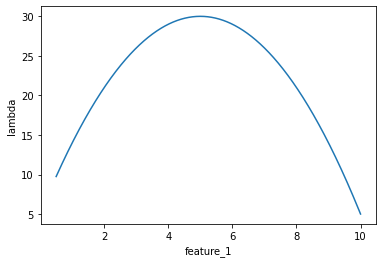

In [77]:
# generate data
# we have one feature, feature_1, and Poisson lambda is going to be linear by it

df = pd.DataFrame.from_dict({'feature_1' : np.random.uniform(0.5, 10, 10000)})
df['lambda'] = - df['feature_1']**2 + 10 * df['feature_1'] + 5
df['claim_number'] = np.random.poisson(df['lambda'])
sns.lineplot(data = df, x = 'feature_1', y = 'lambda')
plt.show()

In [50]:
df['log_feature_1'] = np.log(df['feature_1'])
df['squared_feature_1'] = np.power(df['feature_1'], 2)
df['log_squared_feature_1'] = np.log(np.power(df['feature_1'], 2))

## Random Tests

First, what happens if we just put feature in as it is now? 

In [51]:
mdl = PoissonRegressor(alpha = 0)
X = df[['feature_1']]
y = df['claim_number']
mdl.fit(X, y)
df['pred_claim_number_v1'] = mdl.predict(X)

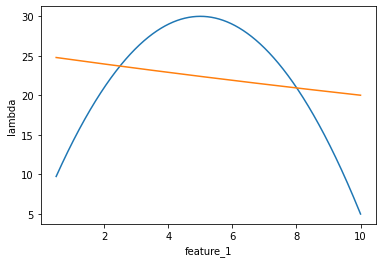

In [52]:
sns.lineplot(data = df, x = 'feature_1', y = 'lambda')
sns.lineplot(data = df, x = 'feature_1', y = 'pred_claim_number_v1')
plt.show()

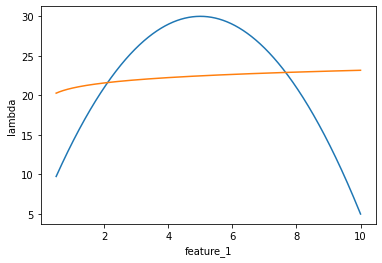

In [55]:
mdl = PoissonRegressor(alpha = 0)
X = df[['log_feature_1']]
y = df['claim_number']
mdl.fit(X, y)
df['pred_claim_number_v1'] = mdl.predict(X)

sns.lineplot(data = df, x = 'feature_1', y = 'lambda')
sns.lineplot(data = df, x = 'feature_1', y = 'pred_claim_number_v1')
plt.show()

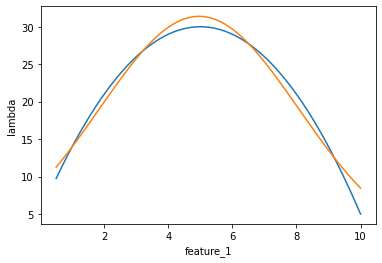

In [56]:
mdl = PoissonRegressor(alpha = 0)
X = df[['feature_1', 'squared_feature_1']]
y = df['claim_number']
mdl.fit(X, y)
df['pred_claim_number_v1'] = mdl.predict(X)

sns.lineplot(data = df, x = 'feature_1', y = 'lambda')
sns.lineplot(data = df, x = 'feature_1', y = 'pred_claim_number_v1')
plt.show()

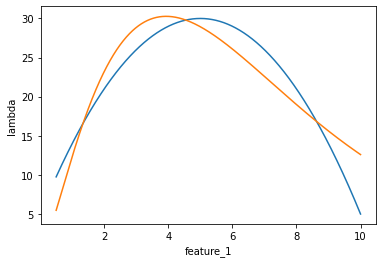

In [57]:
mdl = PoissonRegressor(alpha = 0)
X = df[['feature_1', 'log_feature_1']]
y = df['claim_number']
mdl.fit(X, y)
df['pred_claim_number_v1'] = mdl.predict(X)

sns.lineplot(data = df, x = 'feature_1', y = 'lambda')
sns.lineplot(data = df, x = 'feature_1', y = 'pred_claim_number_v1')
plt.show()

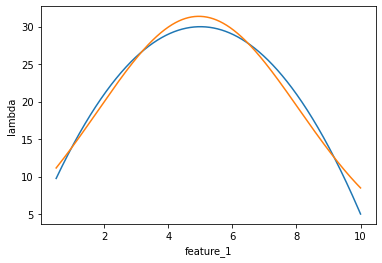

In [58]:
mdl = PoissonRegressor(alpha = 0)
X = df[['feature_1', 'squared_feature_1', 'log_feature_1', 'log_squared_feature_1']]
y = df['claim_number']
mdl.fit(X, y)
df['pred_claim_number_v1'] = mdl.predict(X)

sns.lineplot(data = df, x = 'feature_1', y = 'lambda')
sns.lineplot(data = df, x = 'feature_1', y = 'pred_claim_number_v1')
plt.show()

I think this is the same as the 2nd try, the log probably cancels something out. 

## Analysis

The simple squared thingy seemed to work OK, I wonder why though... Let's try to replicate. 

In [59]:
mdl = PoissonRegressor(alpha = 0)
X = df[['feature_1', 'squared_feature_1']]
y = df['claim_number']
mdl.fit(X, y)
df['pred_claim_number_v1'] = mdl.predict(X)

In [60]:
mdl.coef_

array([ 0.51203886, -0.05162212])

In [61]:
mdl.intercept_

2.176817226463123

In [62]:
df.head(3)

,feature_1,lambda,claim_number,pred_claim_number_v1,log_feature_1,squared_feature_1,log_squared_feature_1
0,1.629440,18.639326,21,17.709360,0.488236,2.655075,0.976473
1,9.894818,6.040754,5,8.927709,2.292011,97.907428,4.584022
2,8.828186,15.344993,14,14.496762,2.177950,77.936866,4.355899


Let's take the third one. 
- feature_1 = 8.828186
- pred_claim_number_v1 = 14.496762

In [64]:
linear_predictor = mdl.intercept_ + \
    mdl.coef_[0] * df.feature_1[2] + mdl.coef_[1] * df.feature_1[2]**2

In [65]:
np.exp(linear_predictor)

14.496762317945546

In [66]:
np.exp(2.176817226463123)

8.818195228513538

In [68]:
np.exp(0.51203886 * 8.828186)

91.86997804533122

In [69]:
np.exp(-0.05162212 * 8.828186 ** 2)

0.017894419850500026

In [70]:
8.8181 * 91.8699 * 0.0178

14.420099780382

I don't know. It shouldn't work. :D Let's plot the coefs by individual feature part. 

In [72]:
df["prediction_coef_feature_1"] = np.exp(mdl.coef_[0] * df['feature_1'])
df["prediction_coef_squared_feature_1"] = np.exp(mdl.coef_[1] * df['squared_feature_1'])
df['prediction_test'] = np.exp(mdl.intercept_) * df['prediction_coef_feature_1'] * \
    df['prediction_coef_squared_feature_1']

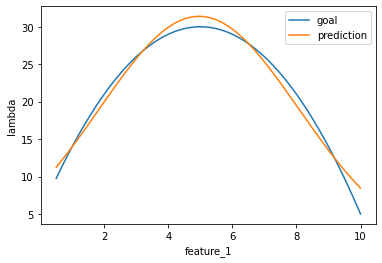

In [74]:
sns.lineplot(data = df, x = 'feature_1', y = 'lambda', label = 'goal')
sns.lineplot(data = df, x = 'feature_1', y = 'pred_claim_number_v1', label = 'prediction')
plt.legend()
plt.show()

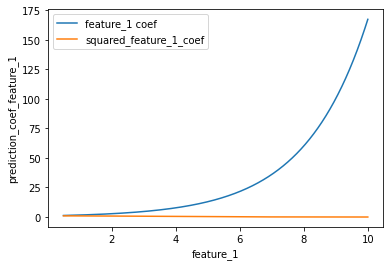

In [76]:
sns.lineplot(data = df, x = 'feature_1', y = 'prediction_coef_feature_1', label = 'feature_1 coef')
sns.lineplot(data = df, x = 'feature_1', y = 'prediction_coef_squared_feature_1', label = 'squared_feature_1_coef')
plt.legend()
plt.show()

# Double-Log

What happens if the real-life relationship is already logarithmic between the feature and the lambda parameter. 